In [1]:
import json

import numpy as np
import matplotlib.pylab as plt

from multistate_extrusion.generators.Translocator import Translocator

from multistate_extrusion.engines.SymmetricExtruder import SymmetricExtruder
from multistate_extrusion.engines.SymmetricExtruderDynamicBoundary import SymmetricExtruderDynamicBoundary

# Extrusion dictionary

In [2]:
with open("../data/extrusion_dict.json", 'r') as dict_file:
    paramdict = json.load(dict_file)


In [3]:
monomers_per_replica = paramdict['monomers_per_replica'] 
sites_per_monomer = paramdict['sites_per_monomer']

sites_per_replica = monomers_per_replica*sites_per_monomer

In [4]:
# Work with a single type of monomers (A, assigned to type index 0)
type_list = ['A']

monomer_types = type_list.index('A') * np.ones(monomers_per_replica, dtype=int)
site_types = np.repeat(monomer_types, sites_per_monomer)

In [5]:
# LEF/CTCF properties in type A monomers may be obtained from the paramdict as follows
LEF_off_rate = paramdict['LEF_off_rate']
CTCF_facestall = paramdict['CTCF_facestall']

print(1./LEF_off_rate['A'], CTCF_facestall['A'])

822.0 1.0


# Making extruders

In [6]:
# Create some CTCF boundary sites
tad_size = 200 # in monomers

ctcf_left_positions = np.arange(0, sites_per_replica, tad_size*sites_per_monomer)
ctcf_right_positions = np.arange(0, sites_per_replica, tad_size*sites_per_monomer)

In [7]:
translocator = Translocator(SymmetricExtruder,
                            type_list, 
                            site_types,
                            ctcf_left_positions,
                            ctcf_right_positions, 
                            **paramdict)

# Running the simulation

In [8]:
translocator.run()

In [9]:
hist = []
frac_bound_LEFs = np.zeros(translocator.params['steps'])

for i, lef_pos in enumerate(translocator.lef_trajectory):
    frac_bound_LEFs[i] = len(lef_pos) / float(translocator.engine.num_LEF)

    hist.extend(lef_pos)

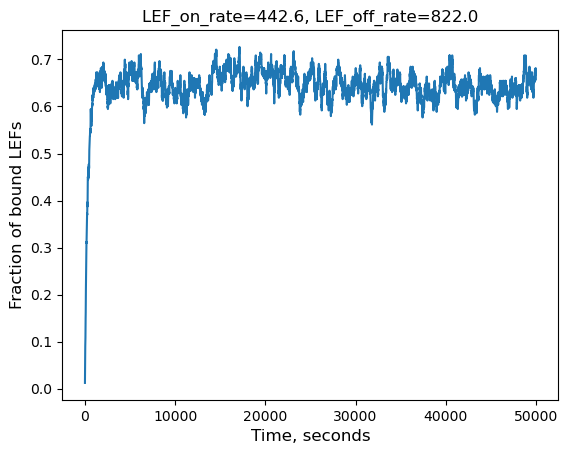

In [10]:
times = np.arange(translocator.params['steps']) * translocator.time_unit

plt.plot(times, frac_bound_LEFs)

plt.title('LEF_on_rate=%.1f, LEF_off_rate=%.1f' % (1./paramdict['LEF_on_rate']['A'], 
                                                   1./paramdict['LEF_off_rate']['A']))
          
plt.xlabel('Time, seconds', fontsize=12)
plt.ylabel('Fraction of bound LEFs', fontsize=12)

plt.show()

# Kymograph Analysis

In [11]:
def map_from_lefs(dset, sites_per_replica):
    
    ll = np.mod(dset, sites_per_replica)
    ll = ll[ll[:,1] > ll[:,0]]
    
    lmap = np.histogram2d(ll[:,0], ll[:,1], np.arange(sites_per_replica))[0]
    
    return (lmap + lmap.T)

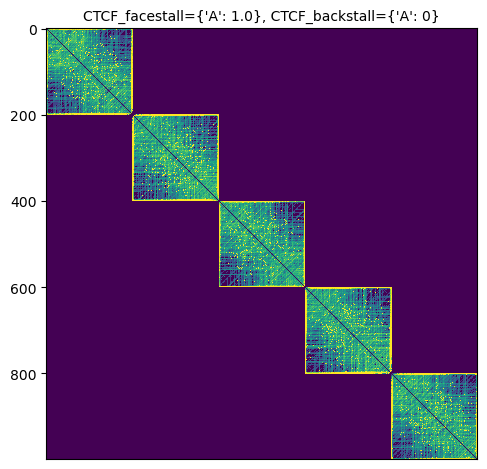

In [12]:
kymograph = map_from_lefs(hist, sites_per_replica)
                    
plt.matshow(np.log10(kymograph+1),vmax=1.5/(np.sqrt(paramdict['sites_per_monomer'])), fignum=False) 
            
plt.title('CTCF_facestall=%s, CTCF_backstall=%s' % (paramdict['CTCF_facestall'],
                                                    paramdict['CTCF_backstall']),
          fontsize=10)

plt.xticks([])
plt.yticks(fontsize=10)
            
plt.tight_layout()
plt.show()                       


# Adding non-homogeneous CTCF boundaries

In [13]:
# Let's make some strong and weak CTCF regions
type_list = ['strong_CTCF', 'weak_CTCF']

site_types[:sites_per_replica//2] = type_list.index('strong_CTCF')
site_types[sites_per_replica//2:] = type_list.index('weak_CTCF')

In [14]:
with open("../data/nonuniform_extrusion_dict.json", 'r') as dict_file:
    paramdict_nonuniform = json.load(dict_file)

In [15]:
# Let's simulate a region with higher CTCF offtime
CTCF_on_rate = paramdict_nonuniform['CTCF_on_rate']

print(CTCF_on_rate['strong_CTCF'], CTCF_on_rate['weak_CTCF'])

0.1 0.001


In [16]:
translocator = Translocator(SymmetricExtruderDynamicBoundary, 
                            type_list,
                            site_types,
                            ctcf_left_positions,
                            ctcf_right_positions, 
                            **paramdict_nonuniform)


In [17]:
translocator.run()

In [18]:
hist = []
frac_bound_CTCFs = np.zeros(translocator.params['steps'])

for i, ctcf_pos in enumerate(translocator.ctcf_trajectory):
    frac_bound_CTCFs[i] = len(ctcf_pos) / float(translocator.engine.num_CTCF)

    hist.extend(translocator.lef_trajectory[i])

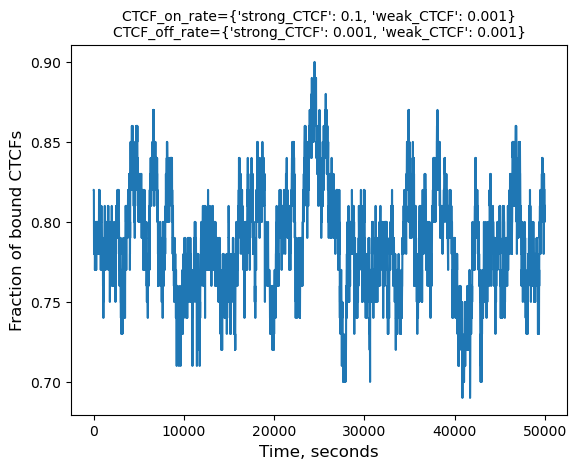

In [19]:
plt.plot(times, frac_bound_CTCFs)

plt.title('CTCF_on_rate=%s\nCTCF_off_rate=%s' % (paramdict_nonuniform['CTCF_on_rate'],
                                                 paramdict_nonuniform['CTCF_off_rate']),
          fontsize=10)
          
plt.xlabel('Time, seconds', fontsize=12)
plt.ylabel('Fraction of bound CTCFs', fontsize=12)

plt.show()

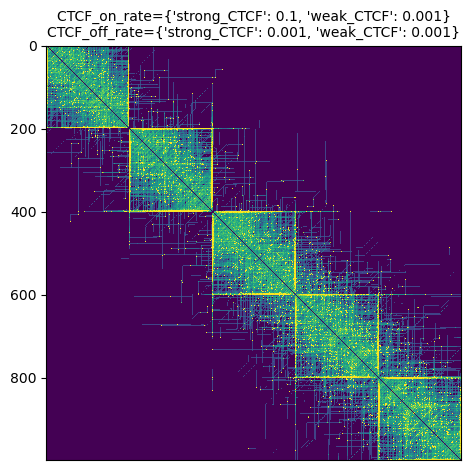

In [20]:
kymograph = map_from_lefs(hist, sites_per_replica)
                    
plt.matshow(np.log10(kymograph+1),vmax=1.5/(np.sqrt(paramdict_nonuniform['sites_per_monomer'])), fignum=False) 
                    
plt.title('CTCF_on_rate=%s\nCTCF_off_rate=%s' % (paramdict_nonuniform['CTCF_on_rate'],
                                                 paramdict_nonuniform['CTCF_off_rate']),
          fontsize=10)

plt.xticks([])
plt.yticks(fontsize=10)
            
plt.tight_layout()
plt.show()

In [21]:
# Or, alternatively, a region with higher CTCF lifetime
paramdict_nonuniform['CTCF_off_rate'] = {"strong_CTCF": 1e-4, "weak_CTCF": 1e-2}
paramdict_nonuniform['CTCF_on_rate'] = {"strong_CTCF": 1e-2, "weak_CTCF": 1e-2}

In [22]:
translocator = Translocator(SymmetricExtruderDynamicBoundary, 
                            type_list,
                            site_types,
                            ctcf_left_positions,
                            ctcf_right_positions, 
                            **paramdict_nonuniform)

In [23]:
translocator.run()

In [24]:
hist = []

for lef_pos in translocator.lef_trajectory:
    hist.extend(lef_pos)

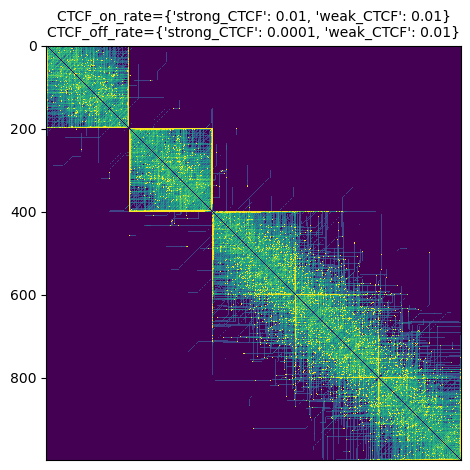

In [25]:
kymograph = map_from_lefs(hist, sites_per_replica)
                    
plt.matshow(np.log10(kymograph+1),vmax=1.5/(np.sqrt(paramdict_nonuniform['sites_per_monomer'])), fignum=False) 
                    
plt.title('CTCF_on_rate=%s\nCTCF_off_rate=%s' % (paramdict_nonuniform['CTCF_on_rate'],
                                                 paramdict_nonuniform['CTCF_off_rate']),
          fontsize=10)

plt.xticks([])
plt.yticks(fontsize=10)
            
plt.tight_layout()
plt.show()                       
